# Demo: Image denoising with an autoencoder

In this demo, we illustrate the use of convolutional networks to build an autoencoder for image denoising. We first load pytorch package and some other common package.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Get training and testing data and preprocessing

We get the natural images cifar10 dataset from `torchvision` build-in function. For more dataset information, you can check [Torchvision Docs](https://pytorch.org/docs/stable/torchvision/datasets.html). 

In [2]:
import torchvision.transforms as transforms

noise_factor = 0.2

def add_noise(image):
    noisy = image + noise_factor*torch.normal(torch.zeros(image.size()), std=1.0)
    noisy = torch.clamp(noisy, 0, 1)
    return image, noisy

transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise
])

In [3]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Create datasets
train_ds = CIFAR10('data/cifar-10', train=True, download=True, transform=transform)
test_ds = CIFAR10('data/cifar-10', train=False, download=True, transform=transform)

# Create Dataloaders
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


We can display 10 original images and corresponding noisy images. First row is original images and second row is noisy images.

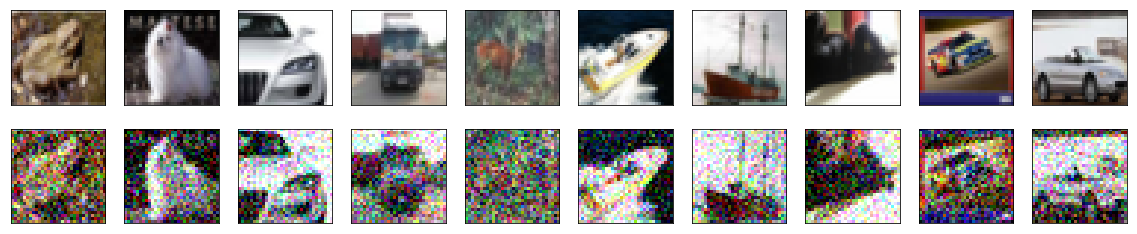

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])


batch = next(iter(train_dl))
images, _ = batch
Ncol = 10
Nrow = 2
plt.figure(figsize=(2*Ncol, 2*Nrow))
for i in range(Ncol):
    for j in range(Nrow):
        ax = plt.subplot(Nrow, Ncol, i+1+j*Ncol)
        imshow(images[j][i])
plt.show()

## Set up an autoencoder and train the model

We construct a very simple auto-encoder with 2 convolution layer encoder each followed by a maxpooling layer (down sample by a factor of 2) and two convolution layer decoder, each followed by a upsampling layer, and a third conv layer that yields the denoised image. The output image has the same size as the input.  We will use batch normalization for each layer. We have found that adding drop out does not have much effect. You could try to add and evaluate the effect.

So far we have declared a network by creating a class with an `__init__` and `forward` methods, and then initializing an instance of that class.
Another way to declare a network is to use `nn.Sequential`, which will concatenate multiple objects of type `nn.Module` and create one network.

For reconstructing an image, a natural choice for the activation function of the output layer would be "linear". However, this does not guarantee the reconstructed values would be in the desired range of 0 to 1. Although we could clip the output image,  through experiments, we have found that using a sigmoid activation function is better. This may in part because it guarantees the output is in the range of 0 to 1. With the same number of epochs, using "linear" activiation yielded more blury images.

In [5]:
import torch.nn as nn
        
model = nn.Sequential(
    nn.Conv2d(3,16,3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.BatchNorm2d(16),
    nn.Conv2d(16,32,3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,32,3, padding=1), nn.ReLU(),
    nn.Upsample(scale_factor=2.0, mode='bilinear'),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,16,3, padding=1), nn.ReLU(),
    nn.Upsample(scale_factor=2.0, mode='bilinear'),
    nn.BatchNorm2d(16),
    nn.Conv2d(16,3,3, padding=1), nn.Sigmoid()
)


We can use summary() function to see model detail.

In [6]:
print(str(model))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Upsample(scale_factor=2.0, mode=bilinear)
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Upsample(scale_factor=2.0, mode=bilinear)
  (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Conv2d(16, 3, ker

As before, to train the network, we have to select an optimizer and a loss function. We select the `MSELoss` loss and the `Adam` optimizer.

In [7]:
import torch.optim as optim
opt = optim.Adam(model.parameters(), lr=0.01)

criterion = nn.MSELoss()

We now fit our model using the noisy version of the images as the input, and the clean version as the true value. Because it takes time to train, we will run a small number of epochs.


In [8]:
import time

nepoch = 3
tr_loss = []
ts_loss = []

tstart = time.time()

for epoch in range(nepoch):
    
    epoch_tr_loss = []
    for i, data in enumerate(train_dl):
        
        images, labels = data
        clean, noisy = images
        
        out = model(noisy)
        loss = criterion(out, clean)
        
        # zero gradient
        opt.zero_grad()
        
        # backpropagation
        loss.backward()
        opt.step()
        epoch_tr_loss.append(loss.item())
        
    tr_loss.append(np.mean(epoch_tr_loss))
    
    epoch_ts_loss = []
    with torch.no_grad():
        for i, data in enumerate(test_dl):

            images, labels = data
            clean, noisy = images

            out = model(noisy)
            epoch_ts_loss.append(criterion(out, clean))
            
    ts_loss.append(np.mean(epoch_ts_loss))
    
    print('Epoch: {0:d}   Tr Loss: {1:.3e}   Ts Loss: {2:.3e}   Time: {3:.2f} sec'.format(epoch+1, tr_loss[epoch], ts_loss[epoch], time.time()-tstart))
    
# Save
PATH = 'autoencoder_3.pt'
torch.save(model.state_dict(), PATH)


/Users/schniter.1/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/Users/schniter.1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 1   Tr Loss: 9.393e-03   Ts Loss: 6.667e-03   Time: 98.71 sec
Epoch: 2   Tr Loss: 6.241e-03   Ts Loss: 5.929e-03   Time: 194.95 sec
Epoch: 3   Tr Loss: 5.862e-03   Ts Loss: 5.855e-03   Time: 289.84 sec


Let us see how the denoised images look. First row is original images, second row is noisy images, and third row shows corresponding denoised images.

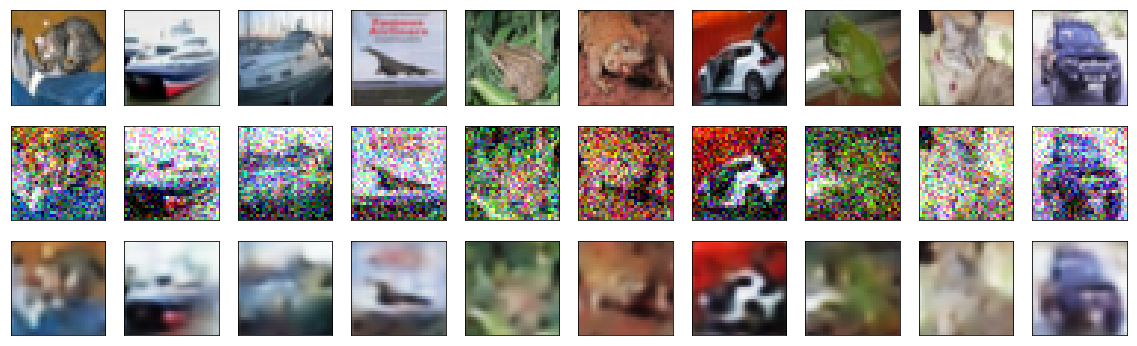

In [9]:
batch = next(iter(test_dl))
images, _ = batch
clean, noisy = images
with torch.no_grad():
    out = model(noisy)
images.append(out.detach())
Ncol = 10
Nrow = 3
plt.figure(figsize=(2*Ncol, 2*Nrow))
for i in range(Ncol):
    for j in range(Nrow):
        ax = plt.subplot(Nrow, Ncol, i+1+j*Ncol)
        imshow(images[j][i])

Because we only run 3 epochs and the training set is relatively small,  the loss is still large. The denoised images look very blurred. If you want to get a more acceptable model to denoise, more epochs and more samples are needed. The following block trains the model using additional 97 epochs, yielding a model trained with 100 epochs. This model is saved, and can be loaded using the load_model() tool.

In [10]:
# Continue to train 97 epochs and save the model
# Skip this step for running the demo in class

nepoch = 97

for epoch in range(nepoch):
    
    epoch_tr_loss = []
    for i, data in enumerate(train_dl):
        
        images, labels = data
        clean, noisy = images
        
        out = model(noisy)
        loss = criterion(out, clean)
        
        # zero gradient
        opt.zero_grad()
        
        # backpropagation
        loss.backward()
        epoch_tr_loss.append(loss.item())
        
    tr_loss.append(np.mean(epoch_tr_loss))
    
    epoch_ts_loss = []
    with torch.no_grad():
        for i, data in enumerate(test_dl):

            images, labels = data
            clean, noisy = images

            out = model(noisy)
            epoch_ts_loss.append(criterion(out, clean).item())
            
    ts_loss.append(np.mean(epoch_ts_loss))
    
    print('Epoch: {0:d}   Tr Loss: {1:.3e}   Ts Loss: {2:.3e}'.format(epoch+4, tr_loss[epoch], ts_loss[epoch]))
    
# Save
PATH = 'autoencoder_100.pt'
torch.save(model.state_dict(), PATH)


Epoch: 4   Tr Loss: 9.393e-03   Ts Loss: 6.667e-03
Epoch: 5   Tr Loss: 6.241e-03   Ts Loss: 5.929e-03
Epoch: 6   Tr Loss: 5.862e-03   Ts Loss: 5.855e-03
Epoch: 7   Tr Loss: 5.774e-03   Ts Loss: 5.855e-03
Epoch: 8   Tr Loss: 5.806e-03   Ts Loss: 5.854e-03
Epoch: 9   Tr Loss: 5.795e-03   Ts Loss: 5.858e-03
Epoch: 10   Tr Loss: 5.783e-03   Ts Loss: 5.852e-03
Epoch: 11   Tr Loss: 5.792e-03   Ts Loss: 5.855e-03
Epoch: 12   Tr Loss: 5.791e-03   Ts Loss: 5.856e-03
Epoch: 13   Tr Loss: 5.782e-03   Ts Loss: 5.855e-03
Epoch: 14   Tr Loss: 5.777e-03   Ts Loss: 5.857e-03
Epoch: 15   Tr Loss: 5.790e-03   Ts Loss: 5.854e-03
Epoch: 16   Tr Loss: 5.785e-03   Ts Loss: 5.856e-03
Epoch: 17   Tr Loss: 5.768e-03   Ts Loss: 5.854e-03
Epoch: 18   Tr Loss: 5.774e-03   Ts Loss: 5.854e-03
Epoch: 19   Tr Loss: 5.767e-03   Ts Loss: 5.856e-03
Epoch: 20   Tr Loss: 5.782e-03   Ts Loss: 5.857e-03
Epoch: 21   Tr Loss: 5.796e-03   Ts Loss: 5.859e-03
Epoch: 22   Tr Loss: 5.773e-03   Ts Loss: 5.856e-03
Epoch: 23   Tr Los

Let us plot the training curves. We can see that although the training loss continuously decreasing, the validation loss is not stable. This is mainly because we used a very small validation set. A larger validation set should lead to a more stable loss curve.

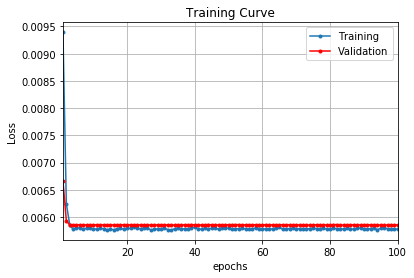

In [11]:
# plot loss curves
# Skip this if you you only trained for 3 epochs.

epochsn=np.arange(1, len(tr_loss) + 1)
plt.plot(epochsn,tr_loss,'.-')
plt.plot(epochsn,ts_loss,'r.-')
plt.xlim((1, len(tr_loss)))

plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend(['Training', 'Validation'])

plt.show()

## Evaluate the denoising performance visually 
Load the pre-trained model if you didn't do the full training.

In [12]:
model = nn.Sequential(
    nn.Conv2d(3,16,3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.BatchNorm2d(16),
    nn.Conv2d(16,32,3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,32,3, padding=1), nn.ReLU(),
    nn.Upsample(scale_factor=2.0, mode='bilinear'),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,16,3, padding=1), nn.ReLU(),
    nn.Upsample(scale_factor=2.0, mode='bilinear'),
    nn.BatchNorm2d(16),
    nn.Conv2d(16,3,3, padding=1), nn.Sigmoid()
)

PATH = 'autoencoder_100.pt'

model.load_state_dict(torch.load(PATH, map_location='cpu'));
model.eval();

Let us see how the denoised images look with this model. We plot denoised images from both the testing set and the training set.

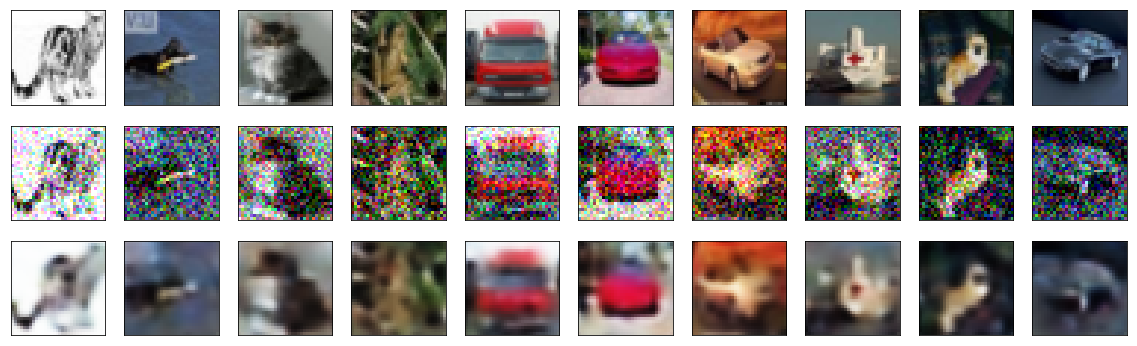

In [13]:
batch = next(iter(train_dl))
images, _ = batch
clean, noisy = images
with torch.no_grad():
    out = model(noisy)
images.append(out.detach())
Ncol = 10
Nrow = 3
plt.figure(figsize=(2*Ncol, 2*Nrow))
for i in range(Ncol):
    for j in range(Nrow):
        ax = plt.subplot(Nrow, Ncol, i+1+j*Ncol)
        imshow(images[j][i])

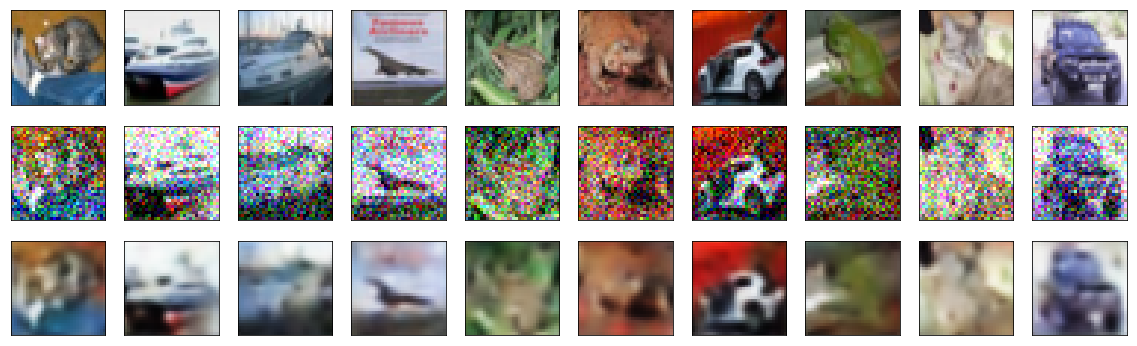

In [14]:
batch = next(iter(test_dl))
images, _ = batch
clean, noisy = images
with torch.no_grad():
    out = model(noisy)
images.append(out.detach())
Ncol = 10
Nrow = 3
plt.figure(figsize=(2*Ncol, 2*Nrow))
for i in range(Ncol):
    for j in range(Nrow):
        ax = plt.subplot(Nrow, Ncol, i+1+j*Ncol)
        imshow(images[j][i])

We see that  with this pretrained model, denoised images for those in training data are noticeably better. For better results, we need to train with more data. Also, using MSE alone often lead to blurred images. Using a advasarial discriminator loss (as in Generative Advasarial Network) in addition to MSE can help to reduce blurring. You can look into those on your own.

## How do the encoded feature maps look?
Let us take a look at encoded image of a test sample. First let us plot an noisy image

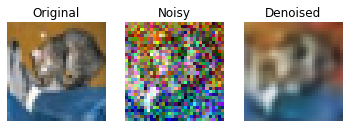

In [15]:
test_original = clean[0]
test_noisy = noisy[0]
test_denoised = out[0]

plt.subplots(1,3)
plt.subplot(1,3,1)
imshow(test_original)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
imshow(test_noisy)
plt.title('Noisy')
plt.axis('off')
plt.subplot(1,3,3)
imshow(test_denoised)
plt.title('Denoised')
plt.axis('off')

plt.show()



We need to declare a feature extractor model like in demo 3 to see the hidden activations

In [16]:
# Code from https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/12 #######
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor,self).__init__()
        self.model = model
        self.layers = layers

    def forward(self, x):
        outputs = []
        # loop over modules
        # feature modules
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.layers:
                outputs += [x]
        
        return x, outputs

##################

feature_extractor = FeatureExtractor(model, ['6'])

Then put test sample into model and plot encoded noised image

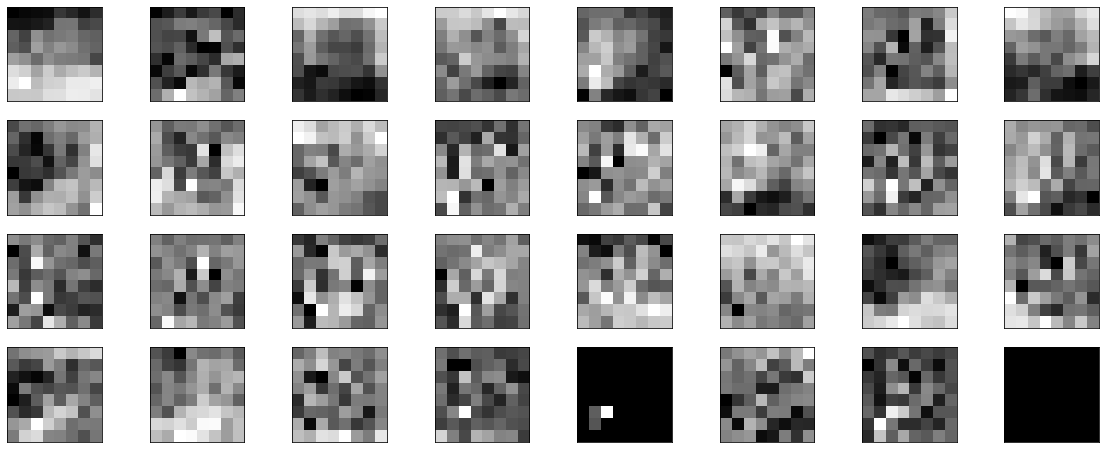

In [17]:
# model input should have 4 dimension: batch_size * length * width * channel
# test_sample_expanded = np.expand_dims(test_sample, axis=0)
test_sample_expanded = test_noisy[None,:,:,:]
out, encode_image = feature_extractor(test_sample_expanded)
n = 8 
plt.figure(figsize=(20, 8))
for i in range(8):
    ax = plt.subplot(4, n, i+1)
    plt.imshow(encode_image[0][0,i,:,:].detach().numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+n+1)
    plt.imshow(encode_image[0][0,i+n,:,:].detach().numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+2*n+1)
    plt.imshow(encode_image[0][0,i+2*n,:,:].detach().numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+3*n+1)
    plt.imshow(encode_image[0][0,i+3*n,:,:].detach().numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We see that some feature maps are completely zero. This suggests that we may not need 32 channels for the encoded features. You may wonder how the decoder generates the denoised image from these features .... That is the mystry of deep network!